아직 ETF 티커를 찾을 수 없음

In [2]:
# https://blog.naver.com/okkam76/221286358499
import datetime as dt

In [3]:
import pandas_datareader.data as web

import pandas as pd
import numpy as np
import scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

In [4]:
# !pip install pandas_datareader

In [5]:
import pandas_datareader.data as web

In [155]:
def get_price_from_morningstar(ticker):
    start = dt.datetime(2010,1,1) # 시작날짜
    end = dt.datetime.now() # 현재날짜

    df = web.DataReader(ticker, 'stooq', start, end) # STOOQ API 사용
    # df.reset_index(inplace=True) # index 재설정
    # df.set_index('Date', inplace=True) # 날짜행 인덱스 지정
    # df = df.drop("Symbol", axis=1) # 종목코드행 삭제
    
    return df

In [156]:
tickers = ["EWA",  # iShares MSCI Australia Index ETF
                        "EWO",  # iShares MSCI Austria Investable Mkt Index ETF
                        "EWK",  # iShares MSCI Belgium Investable Market Index ETF
                        "EWZ",  # iShares MSCI Brazil Index ETF
                        "EWC",  # iShares MSCI Canada Index ETF
                        "FXI",  # iShares China Large-Cap ETF
                        "EWQ",  # iShares MSCI France Index ETF
                        "EWG",  # iShares MSCI Germany ETF 
                        "EWH",  # iShares MSCI Hong Kong Index ETF
                        "EWI",  # iShares MSCI Italy Index ETF
                        "EWJ",  # iShares MSCI Japan Index ETF
                        "EWM",  # iShares MSCI Malaysia Index ETF
                        "EWW",  # iShares MSCI Mexico Inv. Mt. Idx
                        "EWN",  # iShares MSCI Netherlands Index ETF
                        "EWS",  # iShares MSCI Singapore Index ETF
                        "EZA",  # iShares MSCI South Africe Index ETF
                        "EWY",  # iShares MSCI South Korea ETF
                        "EWP",  # iShares MSCI Spain Index ETF
                        "EWD",  # iShares MSCI Sweden Index ETF
                        "EWL",  # iShares MSCI Switzerland Index ETF
                        "EWT",  # iShares MSCI Taiwan Index ETF
                        "THD",  # iShares MSCI Thailand Index ETF
                        "EWU",  # iShares MSCI United Kingdom Index ETF
                        "SPY",  # SPDR S&P 500 ETF
                        ]

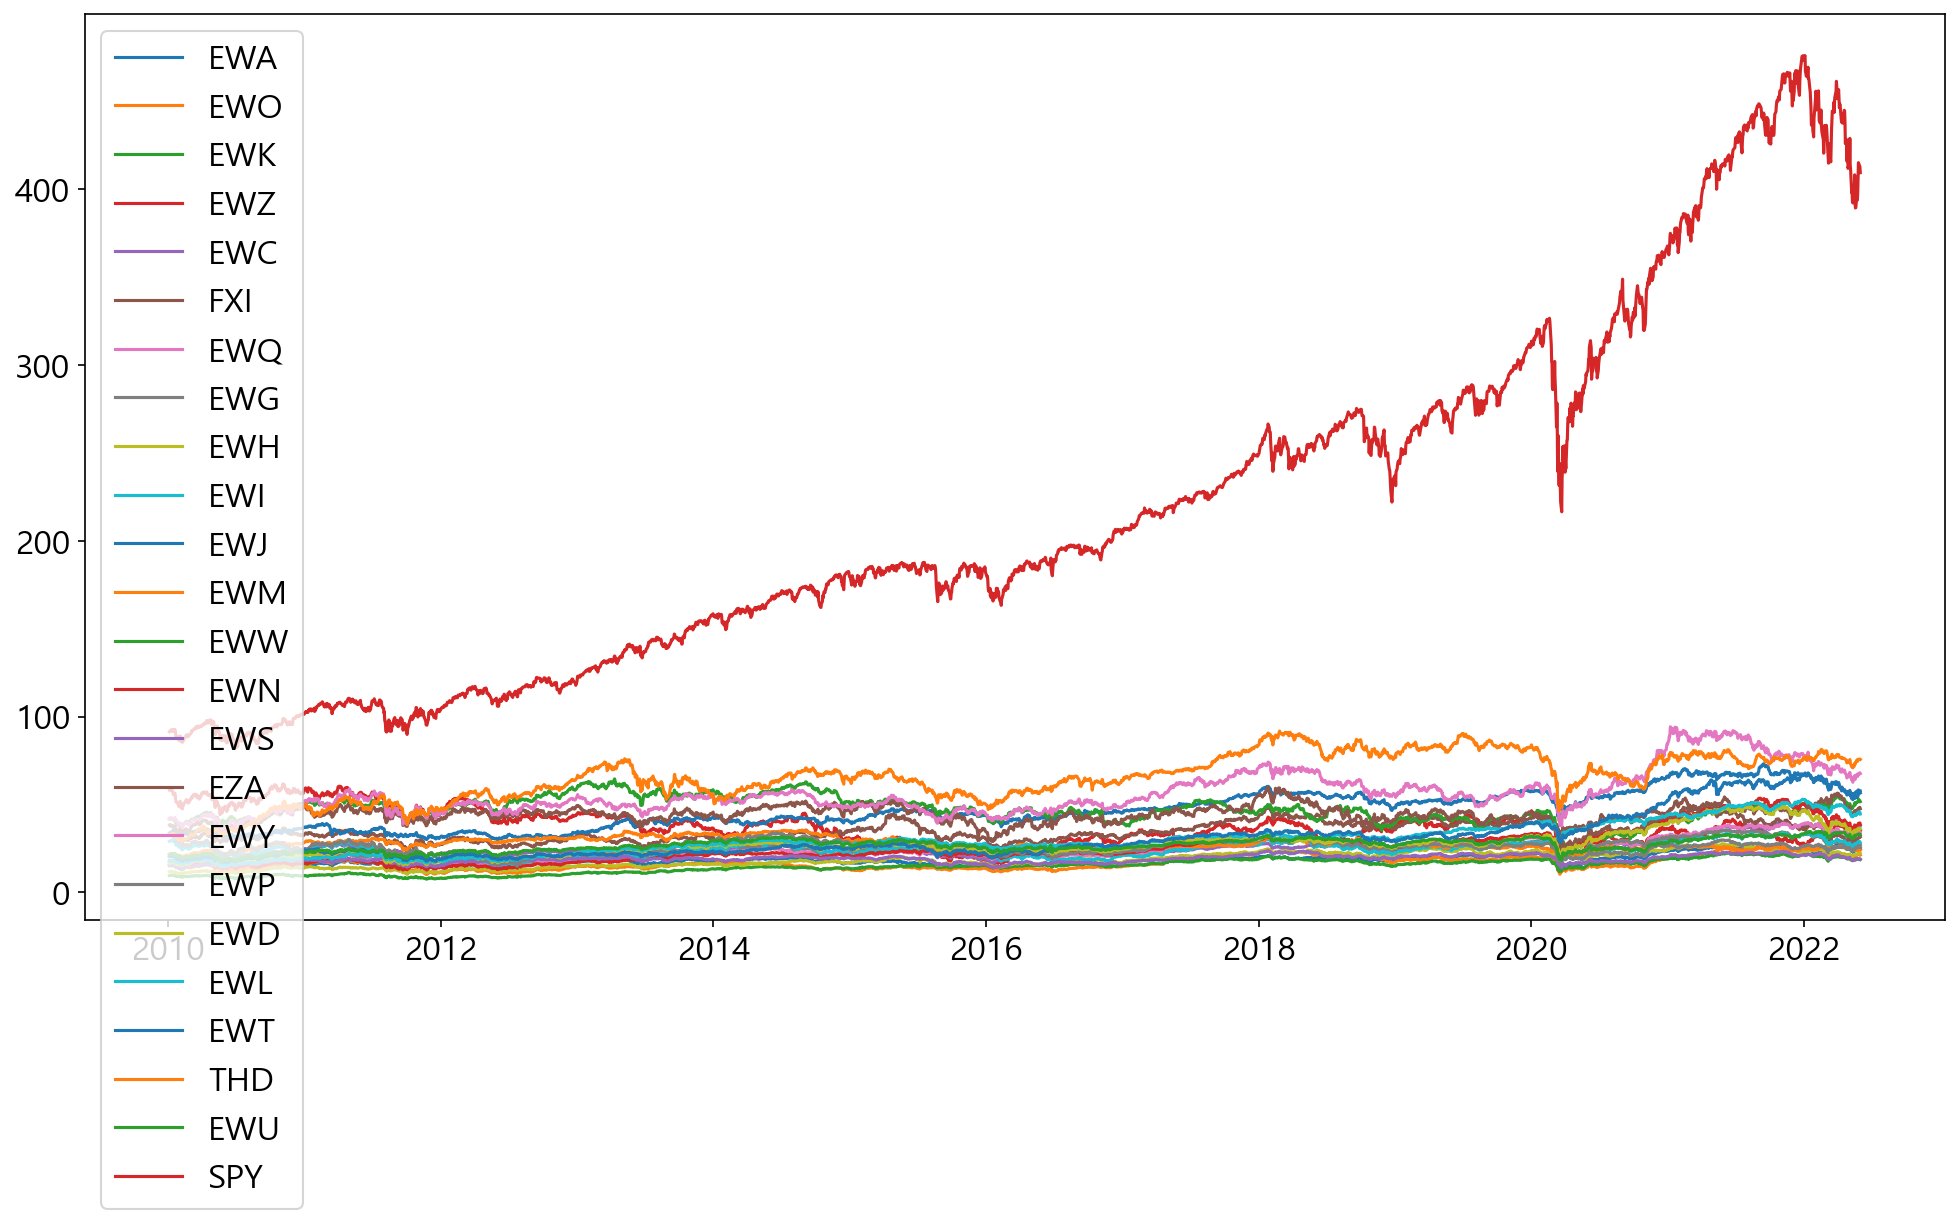

In [157]:
# 종가만 모아보자
# 데이터 시각화
stocks = dict()
legend = []

for ticker in tickers:
    price = get_price_from_morningstar(ticker)
    stocks[ticker] = price['Close'].values[:].tolist()
    legend.append(ticker)

# dict -> Dataframe
prices = pd.DataFrame(stocks)
prices.head()

# index 수정
prices.index = price.index
# prices.head()

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 16
plt.figure(figsize=(16,8))

plt.plot(prices)
plt.legend(legend, loc='upper left')


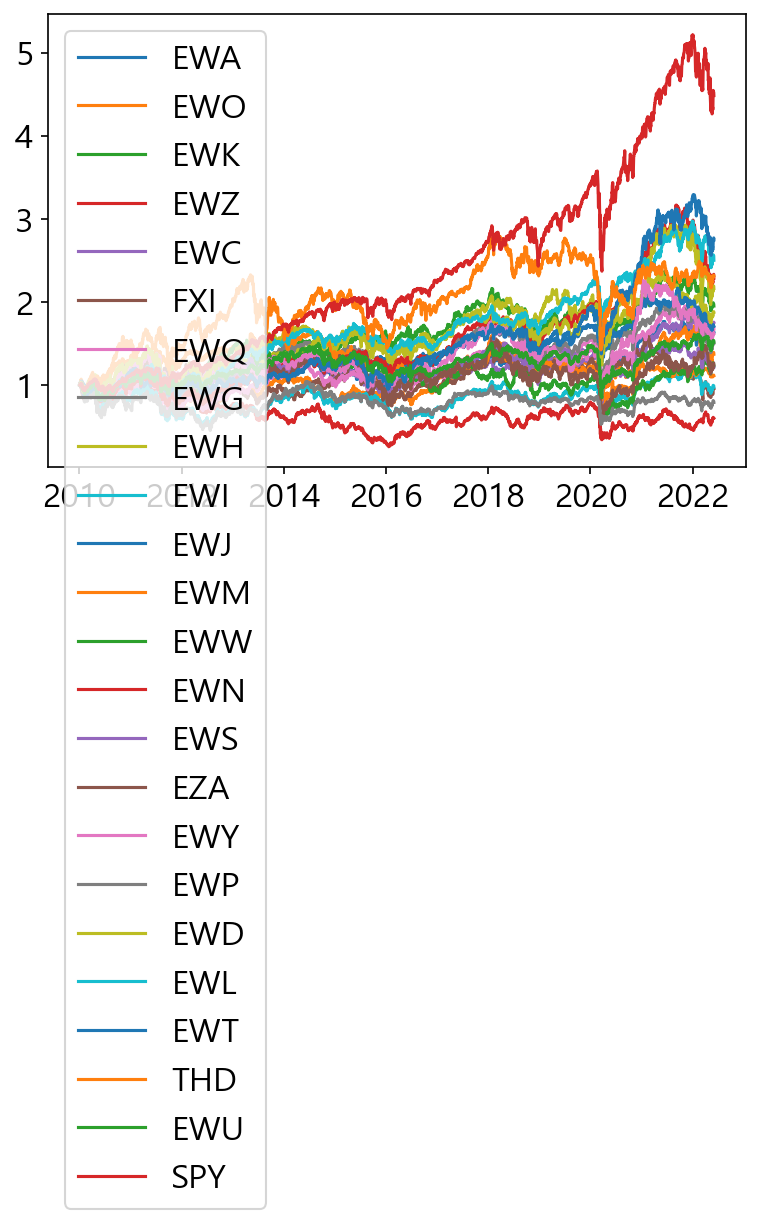

In [159]:
# 누적 수익률로 비교
plt.plot(prices/prices.iloc[-1])
plt.legend(legend, loc='upper left')

In [160]:
prices.sort_index(inplace=True)

In [178]:
import itertools as it

cash = 100000
period = 120
max_traded_pairs = 5 # the top 5 pairs with the smallest distance are used.
total_portfolio_value = dict()
jango_value = 0
# taxrate = 0.00315
taxrate = 0
jango = []

traded_pairs = []
traded_quantity = {}

sorted_pairs = []
symbol_pairs = list(it.combinations(tickers, 2))

In [179]:
# history_price를 만들어서 그걸 업데이트하고 -> 완료
# 다른건 history_price를 바라보게 하면 편할까?

pairs_to_remove = []

def Distance(price_a, price_b):
    # Calculate the sum of squared deviations between two normalized price series
    norm_a = np.array(price_a) / price_a[0]
    norm_b = np.array(price_b) / price_b[0]
    return sum((norm_a - norm_b)**2)

index = period + 1
days = 20
# while index <= prices.shape[0]:
# history_prices = prices.shift(1)[index - period : index]

pairs_to_remove = []

def Distance(price_a, price_b):
    # Calculate the sum of squared deviations between two normalized price series
    norm_a = np.array(price_a) / price_a[0]
    norm_b = np.array(price_b) / price_b[0]
    return sum((norm_a - norm_b)**2)

while index < prices.shape[0] - 1:
    if days == 20:
        # pair 재세팅
        # minimize the sum of squared deviations
        distances = {}
        for pair in symbol_pairs:
            distances[pair] = Distance(history_prices[pair[0]], history_prices[pair[1]])
        
        if len(distances) != 0:
            sorted_pairs = sorted(distances.items(), key= lambda x: x[1])[:max_traded_pairs]
        
        # 포지션 청산
        for pair in traded_pairs:
            if pair in traded_quantity:
                symbol_a = pair[0]
                symbol_b = pair[1]
                a_price = prices[symbol_a].iloc[index] # 당일 종가
                b_price = prices[symbol_b].iloc[index] # 당일 종가
                
                cash += traded_quantity[pair][0] * a_price
                cash -= abs(traded_quantity[pair][0] * a_price) * taxrate
                cash += traded_quantity[pair][1] * b_price
                cash -= abs(traded_quantity[pair][1] * b_price) * taxrate        

        days = 0
        pairs_to_remove = []
        traded_pairs = []
        traded_quantity = {}

        # pair 1개당 거래금액 = 예수금 / 최대 거래가능한 pair
        traded_portfolio_value = cash / max_traded_pairs

    days += 1
    index += 1

    history_prices = prices.shift(1)[index - period + 1 : index + 1]

    for raw_pair in sorted_pairs:
        pair = raw_pair[0]
        # spread 계산
        price_a = history_prices[pair[0]]
        price_b = history_prices[pair[1]]

        norm_a = np.array(price_a) / price_a[0]
        norm_b = np.array(price_b) / price_b[0]

        spread = norm_a - norm_b
        mean = np.mean(spread)
        std = np.std(spread)
        actural_spread = spread[-1]

        # Long-short positon is open when pair prices have diverged by twe standard deviations.
        if actural_spread > mean + 0.5*std or actural_spread < mean - 0.5*std:
            # 조건1) 거래한 pair 리스트에 없다면 거래 시작 
            if pair not in traded_pairs:
                # 조건2) 거래할 수 있는 pair 자리가 있다면 거래 시작
                if len(traded_pairs) < max_traded_pairs:
                    symbol_a = pair[0]
                    symbol_b = pair[1]
                    a_price = prices[symbol_a].iloc[index] # 당일 종가
                    b_price = prices[symbol_b].iloc[index] # 당일 종가
                    a_price_norm = norm_a[-1]
                    b_price_norm = norm_b[-1]

                    # price_a >= price_b
                    if a_price_norm >= b_price_norm: # 이전날 종가 norm 처리 한 것으로 비교
                        long_q = int(traded_portfolio_value / b_price) # long b etf
                        short_q = -int(traded_portfolio_value / a_price) # short a etf
                        
                        # 매수
                        cash -= long_q * b_price
                        cash -= short_q * a_price

                        traded_pairs.append(pair)
                        traded_quantity[pair] = (short_q, long_q)
                    
                    # price_a < price_b
                    if a_price_norm < b_price_norm: # 이전날 종가 norm 처리 한 것으로 비교
                        long_q = int(traded_portfolio_value / a_price) # long a etf
                        short_q = -int(traded_portfolio_value / b_price) # short b etf
                        
                        # 매수
                        cash -= long_q * a_price
                        cash -= short_q * b_price

                        traded_pairs.append(pair)
                        traded_quantity[pair] = (long_q, short_q)
        
        # The position is closed when prices revert back.
        else:
            if pair in traded_pairs and pair in traded_quantity:
                # 청산
                symbol_a = pair[0]
                symbol_b = pair[1]
                a_price = prices[symbol_a].iloc[index] # 당일 종가
                b_price = prices[symbol_b].iloc[index] # 당일 종가
                
                cash += traded_quantity[pair][0] * a_price
                cash -= abs(traded_quantity[pair][0] * a_price) * taxrate
                cash += traded_quantity[pair][1] * b_price
                cash -= abs(traded_quantity[pair][1] * b_price) * taxrate
                
                # traded_pairs.remove(pair)
                # del traded_quantity[pair]
                pairs_to_remove.append(pair)
            
    for pair in pairs_to_remove:
        traded_pairs.remove(pair)
        del traded_quantity[pair]
    
    pairs_to_remove = []

    # 현시점 portfolio 평가금액 계산
    total_portfolio_value[prices.index[index]] = cash
    for pair in traded_pairs:
        if pair in traded_quantity:
            total_portfolio_value[prices.index[index]] += prices[pair[0]].iloc[index] * traded_quantity[pair][0]
            total_portfolio_value[prices.index[index]] += prices[pair[1]].iloc[index] * traded_quantity[pair][1]

    # 테스트
#    print("day:%d, index:%d" %(days, index))
 #   print("평가금액: %.2f, 예수금: %d" % (total_portfolio_value[prices.index[index]], cash))
  #  print(traded_quantity)
   # print(pairs_to_remove)

In [180]:
df_total_value_5 = pd.DataFrame.from_dict(total_portfolio_value, orient='index', columns=['df_total_value_5'])

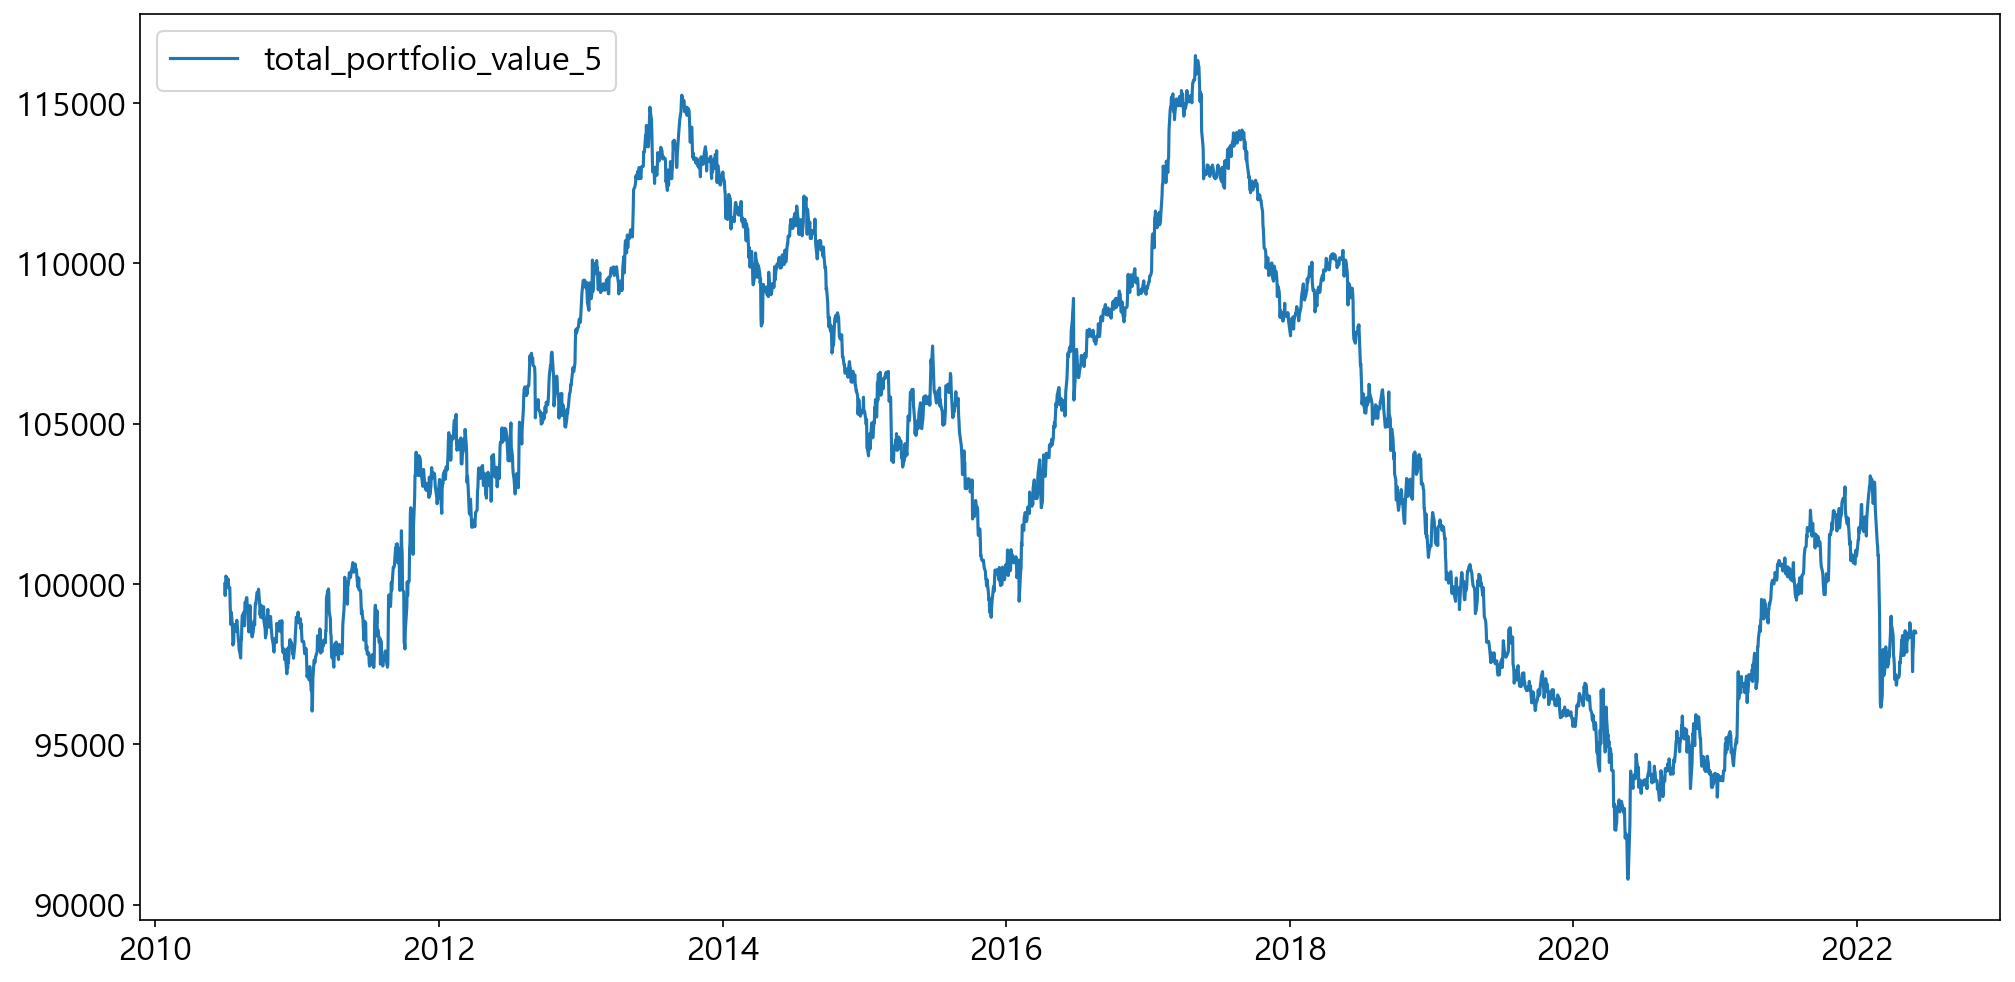

In [181]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 16
plt.figure(figsize=(16,8))

#df_total_value.plot(kind='line')
plt.plot(df_total_value_5)
plt.legend(["total_portfolio_value_5"], loc='upper left')

In [182]:
import itertools as it

cash = 100000
period = 120
max_traded_pairs = 2 # the top 5 pairs with the smallest distance are used.
total_portfolio_value = dict()
jango_value = 0
# taxrate = 0.00315
taxrate = 0
jango = []

traded_pairs = []
traded_quantity = {}

sorted_pairs = []
symbol_pairs = list(it.combinations(tickers, 2))

In [183]:
# history_price를 만들어서 그걸 업데이트하고 -> 완료
# 다른건 history_price를 바라보게 하면 편할까?

pairs_to_remove = []

def Distance(price_a, price_b):
    # Calculate the sum of squared deviations between two normalized price series
    norm_a = np.array(price_a) / price_a[0]
    norm_b = np.array(price_b) / price_b[0]
    return sum((norm_a - norm_b)**2)

index = period + 1
days = 20
# while index <= prices.shape[0]:
# history_prices = prices.shift(1)[index - period : index]

pairs_to_remove = []

def Distance(price_a, price_b):
    # Calculate the sum of squared deviations between two normalized price series
    norm_a = np.array(price_a) / price_a[0]
    norm_b = np.array(price_b) / price_b[0]
    return sum((norm_a - norm_b)**2)

while index < prices.shape[0] - 1:
    if days == 20:
        # pair 재세팅
        # minimize the sum of squared deviations
        distances = {}
        for pair in symbol_pairs:
            distances[pair] = Distance(history_prices[pair[0]], history_prices[pair[1]])
        
        if len(distances) != 0:
            sorted_pairs = sorted(distances.items(), key= lambda x: x[1])[:max_traded_pairs]
        
        # 포지션 청산
        for pair in traded_pairs:
            if pair in traded_quantity:
                symbol_a = pair[0]
                symbol_b = pair[1]
                a_price = prices[symbol_a].iloc[index] # 당일 종가
                b_price = prices[symbol_b].iloc[index] # 당일 종가
                
                cash += traded_quantity[pair][0] * a_price
                cash -= abs(traded_quantity[pair][0] * a_price) * taxrate
                cash += traded_quantity[pair][1] * b_price
                cash -= abs(traded_quantity[pair][1] * b_price) * taxrate        

        days = 0
        pairs_to_remove = []
        traded_pairs = []
        traded_quantity = {}

        # pair 1개당 거래금액 = 예수금 / 최대 거래가능한 pair
        traded_portfolio_value = cash / max_traded_pairs

    days += 1
    index += 1

    history_prices = prices.shift(1)[index - period + 1 : index + 1]

    for raw_pair in sorted_pairs:
        pair = raw_pair[0]
        # spread 계산
        price_a = history_prices[pair[0]]
        price_b = history_prices[pair[1]]

        norm_a = np.array(price_a) / price_a[0]
        norm_b = np.array(price_b) / price_b[0]

        spread = norm_a - norm_b
        mean = np.mean(spread)
        std = np.std(spread)
        actural_spread = spread[-1]

        # Long-short positon is open when pair prices have diverged by twe standard deviations.
        if actural_spread > mean + 0.5*std or actural_spread < mean - 0.5*std:
            # 조건1) 거래한 pair 리스트에 없다면 거래 시작 
            if pair not in traded_pairs:
                # 조건2) 거래할 수 있는 pair 자리가 있다면 거래 시작
                if len(traded_pairs) < max_traded_pairs:
                    symbol_a = pair[0]
                    symbol_b = pair[1]
                    a_price = prices[symbol_a].iloc[index] # 당일 종가
                    b_price = prices[symbol_b].iloc[index] # 당일 종가
                    a_price_norm = norm_a[-1]
                    b_price_norm = norm_b[-1]

                    # price_a >= price_b
                    if a_price_norm >= b_price_norm: # 이전날 종가 norm 처리 한 것으로 비교
                        long_q = int(traded_portfolio_value / b_price) # long b etf
                        short_q = -int(traded_portfolio_value / a_price) # short a etf
                        
                        # 매수
                        cash -= long_q * b_price
                        cash -= short_q * a_price

                        traded_pairs.append(pair)
                        traded_quantity[pair] = (short_q, long_q)
                    
                    # price_a < price_b
                    if a_price_norm < b_price_norm: # 이전날 종가 norm 처리 한 것으로 비교
                        long_q = int(traded_portfolio_value / a_price) # long a etf
                        short_q = -int(traded_portfolio_value / b_price) # short b etf
                        
                        # 매수
                        cash -= long_q * a_price
                        cash -= short_q * b_price

                        traded_pairs.append(pair)
                        traded_quantity[pair] = (long_q, short_q)
        
        # The position is closed when prices revert back.
        else:
            if pair in traded_pairs and pair in traded_quantity:
                # 청산
                symbol_a = pair[0]
                symbol_b = pair[1]
                a_price = prices[symbol_a].iloc[index] # 당일 종가
                b_price = prices[symbol_b].iloc[index] # 당일 종가
                
                cash += traded_quantity[pair][0] * a_price
                cash -= abs(traded_quantity[pair][0] * a_price) * taxrate
                cash += traded_quantity[pair][1] * b_price
                cash -= abs(traded_quantity[pair][1] * b_price) * taxrate
                
                # traded_pairs.remove(pair)
                # del traded_quantity[pair]
                pairs_to_remove.append(pair)
            
    for pair in pairs_to_remove:
        traded_pairs.remove(pair)
        del traded_quantity[pair]
    
    pairs_to_remove = []

    # 현시점 portfolio 평가금액 계산
    total_portfolio_value[prices.index[index]] = cash
    for pair in traded_pairs:
        if pair in traded_quantity:
            total_portfolio_value[prices.index[index]] += prices[pair[0]].iloc[index] * traded_quantity[pair][0]
            total_portfolio_value[prices.index[index]] += prices[pair[1]].iloc[index] * traded_quantity[pair][1]

    # 테스트
#    print("day:%d, index:%d" %(days, index))
 #   print("평가금액: %.2f, 예수금: %d" % (total_portfolio_value[prices.index[index]], cash))
  #  print(traded_quantity)
   # print(pairs_to_remove)

In [184]:
df_total_value_2 = pd.DataFrame.from_dict(total_portfolio_value, orient='index', columns=['df_total_value_2'])

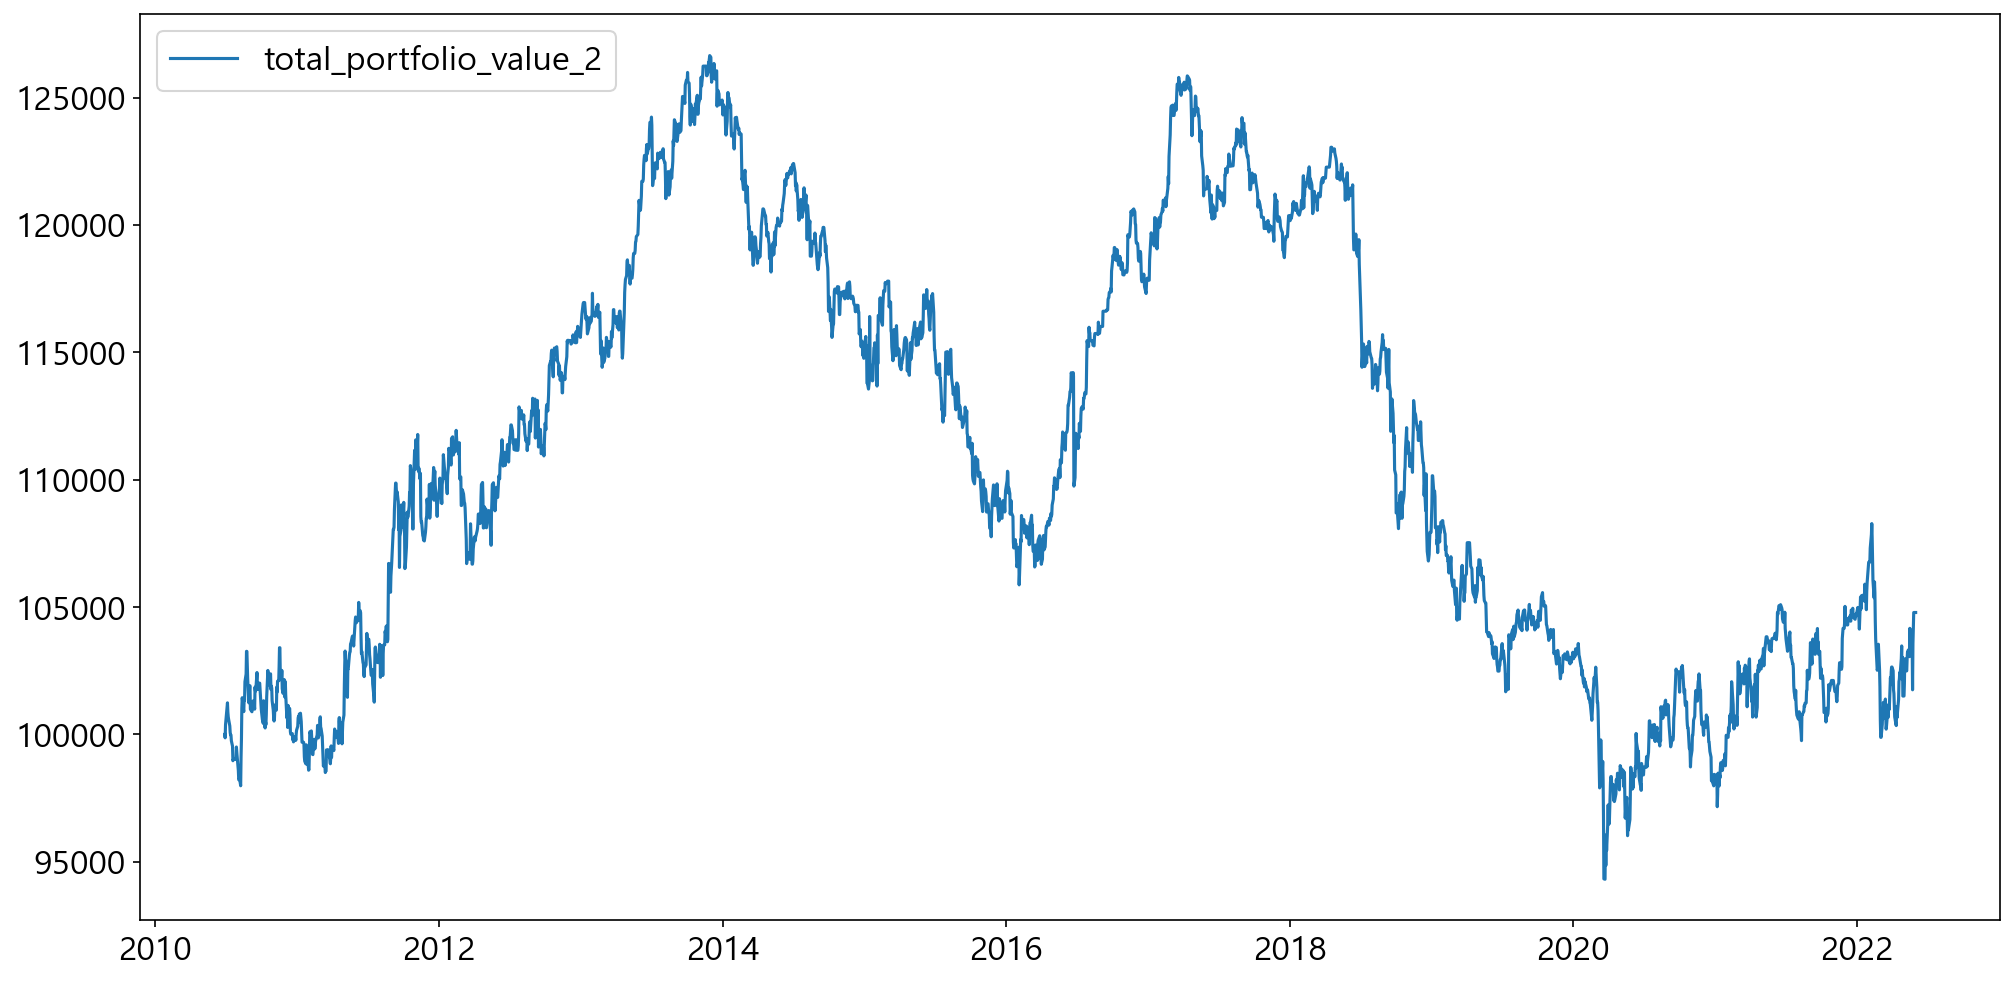

In [185]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 16
plt.figure(figsize=(16,8))

#df_total_value.plot(kind='line')
plt.plot(df_total_value_2)
plt.legend(["total_portfolio_value_2"], loc='upper left')

In [191]:
df = pd.concat([df_total_value_2, df_total_value_5], axis=1)

In [192]:
df.head()

,df_total_value_2,df_total_value_5
2010-06-29,100000.000,100000.000
2010-06-30,99862.082,99641.056
2010-07-01,100378.356,99934.283
2010-07-02,100558.132,100246.785
2010-07-06,101236.746,100112.337


<AxesSubplot:>

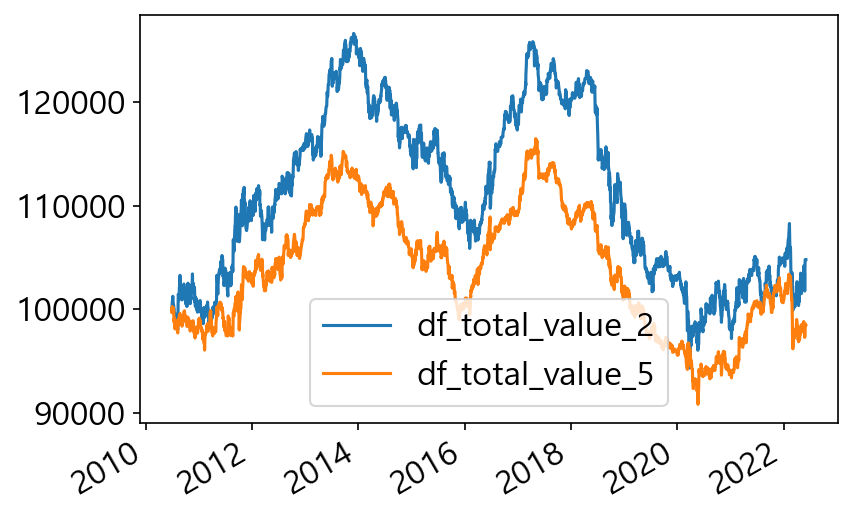

In [193]:
df.plot(kind='line')

In [194]:
def drawdown(returns):
    cumulative = (1 + returns).cumprod()
    highwatermark = cumulative.cummax()
    drawdown = (cumulative /  highwatermark) - 1
    return drawdown

def maximum_drawdown(returns):
    return np.min(drawdown(returns))

In [197]:
(df.pct_change(1)).apply(drawdown)

,df_total_value_2,df_total_value_5
2010-06-29,NaN,NaN
2010-06-30,0.000000,0.000000
2010-07-01,0.000000,0.000000
2010-07-02,0.000000,0.000000
2010-07-06,0.000000,-0.001341
...,...,...
2022-05-25,-0.182271,-0.159558
2022-05-26,-0.177312,-0.158066
2022-05-27,-0.172635,-0.154083
2022-05-31,-0.172635,-0.154083


c:\python\venv32bit\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


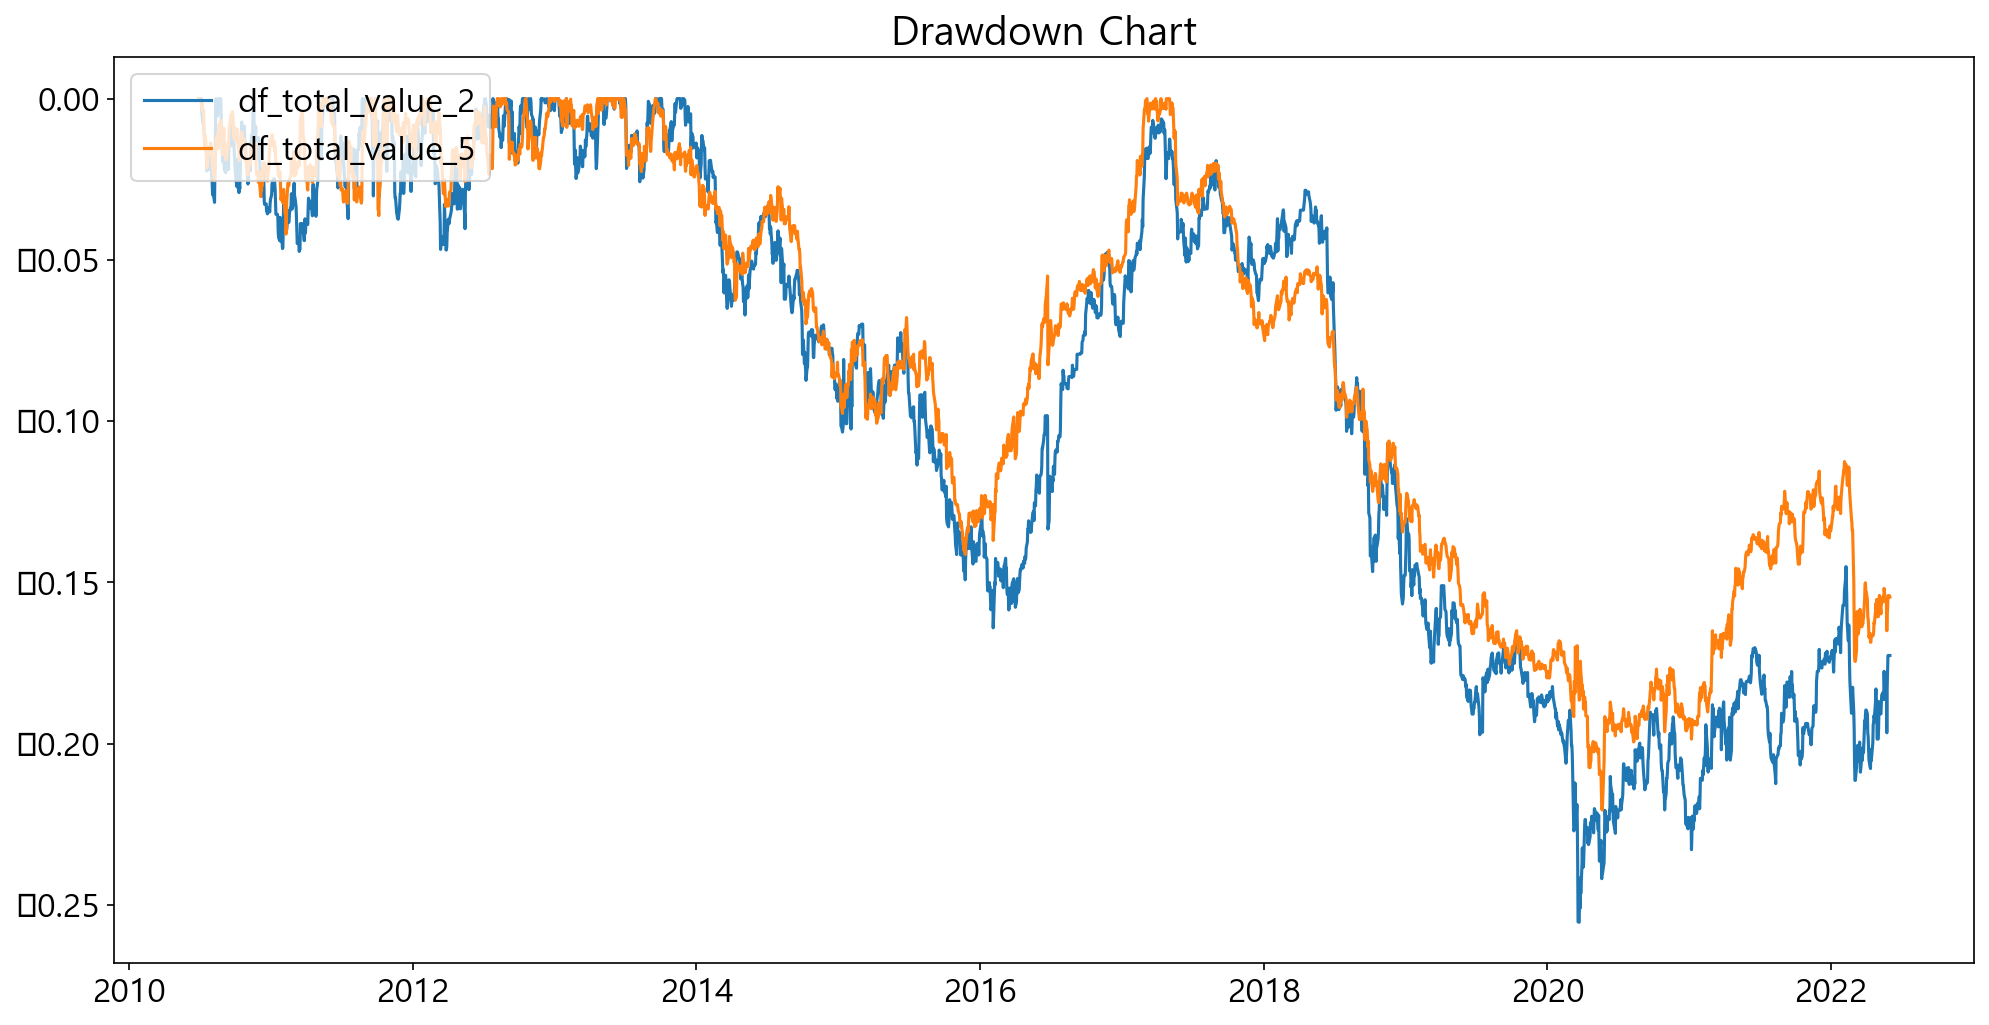

In [198]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 16
plt.figure(figsize=(16, 8))

plt.title("Drawdown Chart")
plt.plot(df.pct_change(1).apply(drawdown))
plt.legend(list(df.columns), loc='upper left')

In [199]:
# MDD 계산
df.pct_change(1).apply(maximum_drawdown)

df_total_value_2   -0.255324
df_total_value_5   -0.220537
dtype: float64

In [205]:
# pd.Series -> pd.DataFrame
df_stat = ((df/df.iloc[0]).iloc[-1].pow(252/df.shape[0])-1).to_frame(name='CAGR')

In [206]:
df_stat['MDD'] = df.pct_change(1).apply(maximum_drawdown)

In [207]:
df_stat

,CAGR,MDD
df_total_value_2,0.003930,-0.255324
df_total_value_5,-0.001287,-0.220537
